In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_precision
from tqdm import tqdm
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, ConcatDataset


In [2]:
selected_classes = [3, 4, 7]
pickle_dir = 'pickles'
pytorch_chkpt_dir = 'pt-saves'
pretrained_model_path = f"{pytorch_chkpt_dir}/mnist_pt.pth"

In [3]:
# create folder if not exists
os.makedirs(pickle_dir, exist_ok=True)
os.makedirs(pytorch_chkpt_dir, exist_ok=True)

In [4]:
# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Input layer (MNIST images are 28x28)
        self.fc2 = nn.Linear(128, 64)     # Hidden layer
        self.fc3 = nn.Linear(64, 10)      # Output layer (10 classes for MNIST digits)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))  # ReLU activation for the first layer
        x = torch.relu(self.fc2(x))  # ReLU activation for the second layer
        x = self.fc3(x)  # Output layer
        return x

In [5]:
# def train_model(model, train_loader, num_epochs=20, fine_tuning=False):
#     # Loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     # Set the model to training mode
#     model.train()
#     # Training loop
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         # Create a progress bar for the current epoch
#         with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
#             for inputs, labels in train_loader:
#                 # Zero the gradients
#                 optimizer.zero_grad()
#                 # Forward pass
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 # Backward pass and optimization
#                 loss.backward()
#                 optimizer.step()
#                 # Track the running loss
#                 running_loss += loss.item()
#                 # Update the progress bar
#                 pbar.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})
#                 pbar.update(1)
#     if fine_tuning:
#         print("Fine-tuning complete!")
#     else:
#         print("Training complete!")

In [ ]:
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import torch.nn as nn
# import torch.optim as optim

# def train_model(model, train_loader, test_loader, num_epochs=20, fine_tuning=False):
#     # Loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
    
#     # Initialize lists to track metrics
#     train_losses, test_losses = [], []
#     train_accuracies, test_accuracies = [], []

#     # Training loop
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         # Set the model to training mode
#         model.train()
        
#         # Create a progress bar for the current epoch
#         with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
#             for inputs, labels in train_loader:
#                 # Zero the gradients
#                 optimizer.zero_grad()
#                 # Forward pass
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 # Backward pass and optimization
#                 loss.backward()
#                 optimizer.step()
#                 # Track the running loss
#                 running_loss += loss.item()
#                 # Calculate accuracy
#                 _, predicted = torch.max(outputs, 1)
#                 correct += (predicted == labels).sum().item()
#                 total += labels.size(0)
#                 # Update the progress bar
#                 pbar.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})
#                 pbar.update(1)

#         train_loss = running_loss / len(train_loader)
#         train_losses.append(train_loss)
#         train_accuracy = correct / total
#         train_accuracies.append(train_accuracy)

#         # Evaluate on the test set
#         model.eval()
#         test_loss = 0.0
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, labels in test_loader:
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 test_loss += loss.item()
#                 _, predicted = torch.max(outputs, 1)
#                 correct += (predicted == labels).sum().item()
#                 total += labels.size(0)

#         test_loss /= len(test_loader)
#         test_losses.append(test_loss)
#         test_accuracy = correct / total
#         test_accuracies.append(test_accuracy)

#         print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

#     if fine_tuning:
#         print("Fine-tuning complete!")
#     else:
#         print("Training complete!")

#     # Plot the metrics
#     plt.figure(figsize=(12, 5))

#     # Plot loss
#     plt.subplot(1, 2, 1)
#     plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
#     plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Loss Curve')
#     plt.legend()

#     # Plot accuracy
#     plt.subplot(1, 2, 2)
#     plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
#     plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Accuracy Curve')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch

def train_model(model, train_loader, test_loader, num_epochs=20, fine_tuning=False):
    # Check if CUDA (GPU) is available and set device accordingly
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}")

    # Move the model to GPU (if available)
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Initialize lists to track metrics
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Set the model to training mode
        model.train()
        
        # Create a progress bar for the current epoch
        with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
            for inputs, labels in train_loader:
                # Move data to GPU (if available)
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                # Track the running loss
                running_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                
                # Update the progress bar
                pbar.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})
                pbar.update(1)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Evaluate on the test set
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Move data to GPU (if available)
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    if fine_tuning:
        print("Fine-tuning complete!")
    else:
        print("Training complete!")

    # Plot the metrics
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [6]:
def load_from_pickle(pickle_name):
    pickled_data = pickle.load(open(f"{pickle_dir}/{pickle_name}", "rb"))
    return DataLoader(pickled_data, batch_size=32, shuffle=True)

In [7]:
def load_pretrained_model():
    model_pt = SimpleNN()
    mnist_pt = torch.load(pretrained_model_path)
    model_pt.load_state_dict(mnist_pt)
    return model_pt

In [8]:
def evaluate_model(model, test_loader):
    # Set the model to evaluation mode
    model.eval()
    # Initialize variables to track the predictions and true labels
    all_predictions = []
    all_labels = []
    # No gradients needed for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Forward pass: Get model predictions
            outputs = model(inputs)
            
            # Get the predicted class by finding the class with the highest score
            _, predicted = torch.max(outputs, 1)
            
            # Store the predictions and true labels for metric calculation
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    cr = classification_report(all_labels, all_predictions)
    print(f'Classification report for tain data:\n{cr}')

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8)) 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10)) 
    plt.title('Confusion Matrix') 
    plt.xlabel('Predicted') 
    plt.ylabel('True') 
    plt.show()

In [9]:
def plot_mnist_data(loader):
    images, labels = next(iter(loader))
    # Create a grid of images (8x8) for display
    grid = torchvision.utils.make_grid(images[:64], nrow=8, padding=2, normalize=True)
    # Display the images in a grid
    plt.figure(figsize=(4, 8))
    plt.imshow(grid.permute(1, 2, 0))  # Rearrange dimensions for matplotlib (H x W x C)
    plt.axis('off')
    plt.title("Sample MNIST Images")
    plt.show()

## Part 1: Split Data

In [10]:
# Define the transformations to apply to each image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

In [11]:
# Load the MNIST training and testing datasets
mnist_train = torchvision.datasets.MNIST(
    root='./data',  # Directory where the data will be stored
    train=True,     # Load the training dataset
    transform=transform,  # Apply the transformations
    download=True   # Download the dataset if not already present
)

In [67]:
import torch
from torchvision import datasets, transforms
import pandas as pd

# Define the transformation to apply to the images (e.g., convert to tensor)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Extracting images and labels
images, labels = mnist_train.data, mnist_train.targets

# Check for missing values in the dataset (if data were tabular)
# Convert to a DataFrame (flatten the images and add labels as columns)
df = pd.DataFrame(images.view(-1, 28*28).numpy())  # Flatten the images

# Add the labels as a column
df['label'] = labels.numpy()

# Check for missing values
missing_values = df.isnull().sum()

# Print the missing values for each column
print(missing_values)


0        0
1        0
2        0
3        0
4        0
        ..
780      0
781      0
782      0
783      0
label    0
Length: 785, dtype: int64


In [12]:
mnist_test = torchvision.datasets.MNIST(
    root='./data',
    train=False,    # Load the test dataset
    transform=transform,
    download=True
)

In [13]:
selected = {}
remaining = []
for i in mnist_train:
    if i[1] in selected_classes:
        if i[1] not in selected:
            selected[i[1]] = []
        if len(selected[i[1]]) < 1000:
            selected[i[1]].append(i)
        else:
            remaining.append(i)
    else:
        remaining.append(i)

for sc in selected:
    print(f"Class {sc} has {len(selected[sc])} samples")
    # write training datasets for fine-tuning to pickles
    pickle.dump(selected[sc], open(f"{pickle_dir}/train_{sc}.pkl", "wb"))
# write remaining dataset to separate pickle as well
print(f"Remaining list has {len(remaining)} samples")
pickle.dump(remaining, open(f"{pickle_dir}/train_rem.pkl", "wb"))

Class 4 has 1000 samples
Class 3 has 1000 samples
Class 7 has 1000 samples
Remaining list has 57000 samples


## Part 2: Train Model as Pretrained and Computation of its Functional Metrics

Loading dataset

In [21]:
# load the data from pickle
train_loader = load_from_pickle("train_rem.pkl")
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=True)

Initial EDA

In [32]:
# Check the shape of train_loader
for data, labels in train_loader:
    print(f"Train Data Shape: {data.shape}")
    print(f"Train Labels Shape: {labels.shape}")
    break  # Exit after inspecting the first batch

# Check the shape of test_loader
for data, labels in test_loader:
    print(f"Test Data Shape: {data.shape}")
    print(f"Test Labels Shape: {labels.shape}")
    break  # Exit after inspecting the first batch


Train Data Shape: torch.Size([32, 1, 28, 28])
Train Labels Shape: torch.Size([32])
Test Data Shape: torch.Size([128, 1, 28, 28])
Test Labels Shape: torch.Size([128])


In [44]:
# Function to describe the dataset
def describe_dataset(loader, name):
    num_samples = 0
    classes = set()
    
    for data, labels in loader:
        num_samples += data.size(0)  # Count the number of samples
        classes.update(labels.tolist())  # Add unique classes to the set
    
    print(f"--- {name} Description ---")
    print(f"Total Samples: {num_samples}")
    print(f"Number of Classes: {len(classes)}")
    print(f"Classes: {sorted(classes)}")

# Describe the train and test datasets
describe_dataset(train_loader, "Train Dataset")
describe_dataset(test_loader, "Test Dataset")


--- Train Dataset Description ---
Total Samples: 57000
Number of Classes: 10
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--- Test Dataset Description ---
Total Samples: 10000
Number of Classes: 10
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Visualizing random samples from Train Dataset:


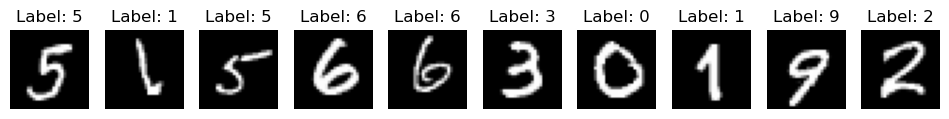

In [46]:
import matplotlib.pyplot as plt

# Visualize random samples
def visualize_random_samples(loader, num_samples=10):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

print("Visualizing random samples from Train Dataset:")
visualize_random_samples(train_loader)


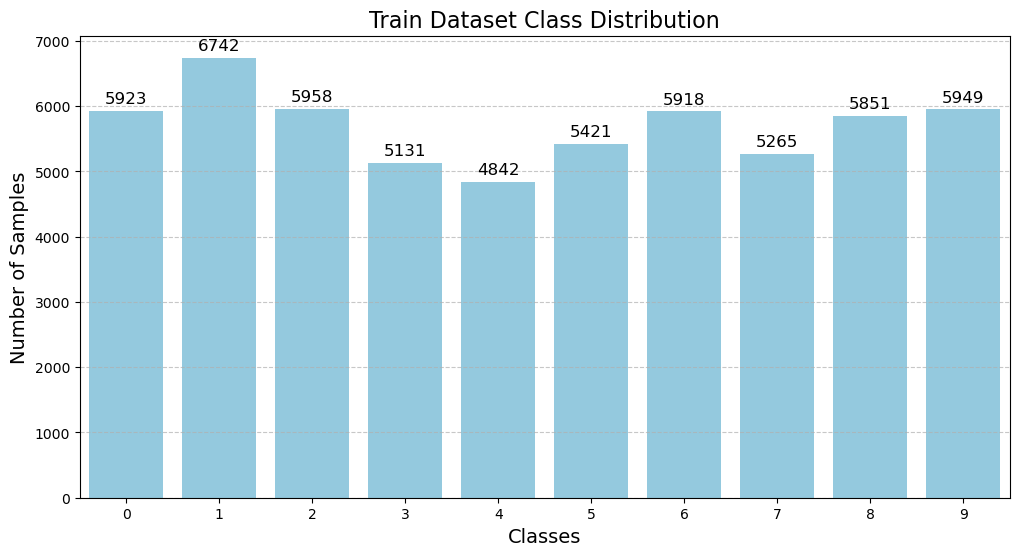

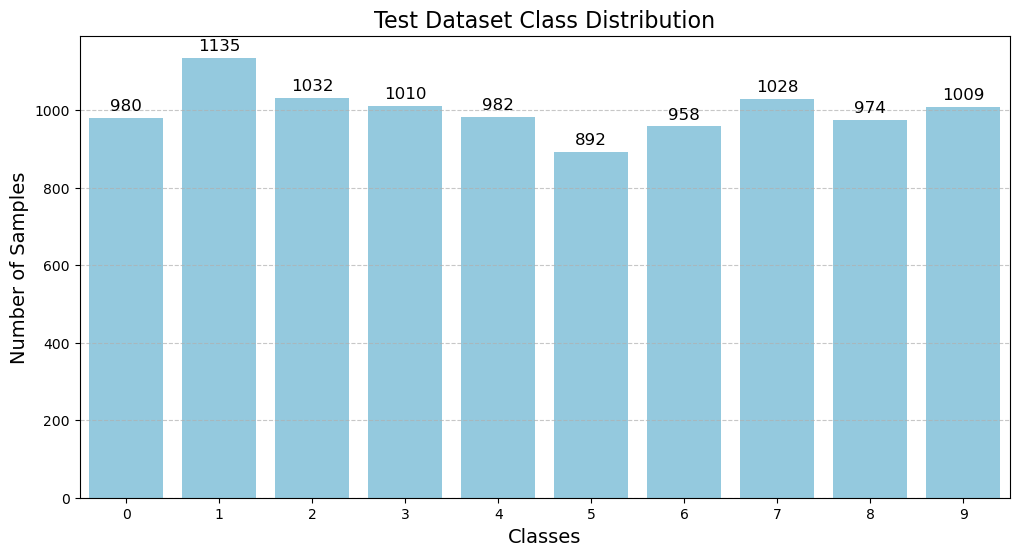

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Function to analyze and visualize class distribution with counts annotated
def analyze_and_plot_class_distribution_seaborn(loader, name):
    # Count the class occurrences
    class_counts = Counter()
    for _, labels in loader:
        class_counts.update(labels.tolist())
    
    # Prepare data for Seaborn
    classes = sorted(class_counts.keys())
    counts = [class_counts[cls] for cls in classes]
    
    # Create a Seaborn bar plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=classes, y=counts, color="skyblue")  # Use a single color
    plt.xlabel("Classes", fontsize=14)
    plt.ylabel("Number of Samples", fontsize=14)
    plt.title(f"{name} Class Distribution", fontsize=16)
    plt.xticks(classes)

    # Annotate counts on top of each bar
    for i, count in enumerate(counts):
        ax.text(i, count + max(counts) * 0.01,  # Adjust position slightly above the bar
                str(count), ha='center', va='bottom', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Analyze and visualize the class distribution for train and test datasets
analyze_and_plot_class_distribution_seaborn(train_loader, "Train Dataset")
analyze_and_plot_class_distribution_seaborn(test_loader, "Test Dataset")


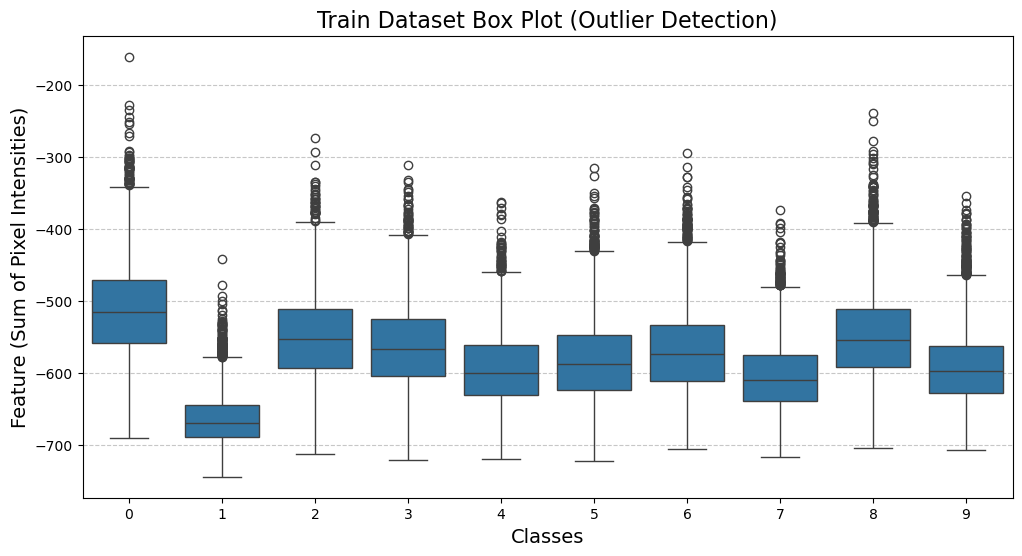

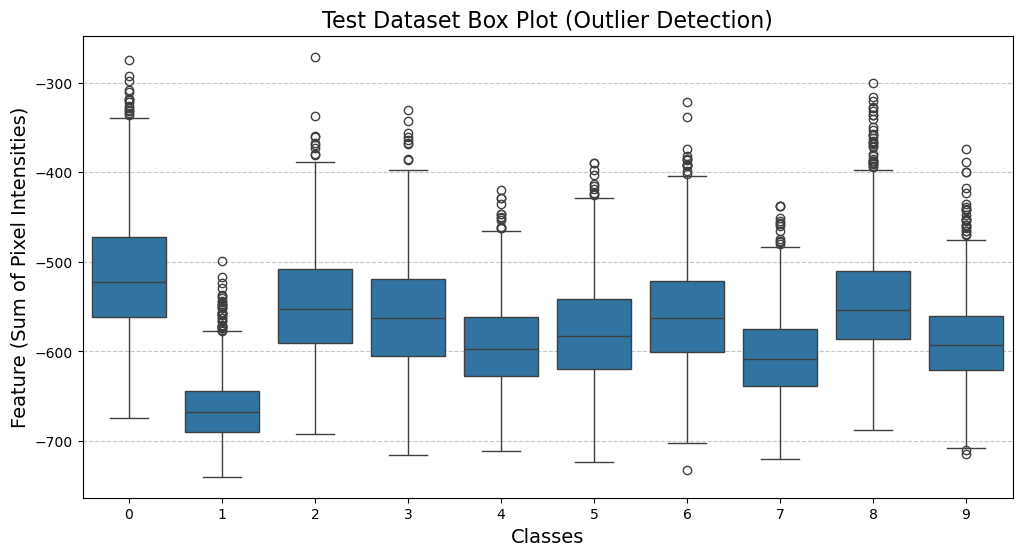

In [57]:
import pandas as pd

# Prepare data for boxplot
def prepare_data_for_boxplot(loader):
    data = []
    for images, labels in loader:
        # Compute a representative feature for boxplot (e.g., sum of pixel values)
        feature = images.view(images.size(0), -1).sum(dim=1).tolist()
        data.extend(zip(labels.tolist(), feature))
    return pd.DataFrame(data, columns=["Class", "Feature"])

# Generate box plot
def plot_boxplot(df, title):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Class", y="Feature", data=df)
    plt.xlabel("Classes", fontsize=14)
    plt.ylabel("Feature (Sum of Pixel Intensities)", fontsize=14)
    plt.title(title, fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Prepare data for train and test loaders
train_df = prepare_data_for_boxplot(train_loader)
test_df = prepare_data_for_boxplot(test_loader)

# Plot boxplots for train and test datasets
plot_boxplot(train_df, "Train Dataset Box Plot (Outlier Detection)")
plot_boxplot(test_df, "Test Dataset Box Plot (Outlier Detection)")


In [59]:
# Initialize the model
model = SimpleNN()

In [61]:
model

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [62]:
# Print the total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal Trainable Parameters: {count_parameters(model)}")


Total Trainable Parameters: 109386


Epoch [1/50]: 100%|██████████| 1782/1782 [00:07<00:00, 237.80batch/s, Loss=0.3641]


Epoch [1/50] - Train Loss: 0.3641, Train Acc: 0.8892, Test Loss: 0.1982, Test Acc: 0.9365


Epoch [2/50]: 100%|██████████| 1782/1782 [00:07<00:00, 239.42batch/s, Loss=0.1753]


Epoch [2/50] - Train Loss: 0.1753, Train Acc: 0.9475, Test Loss: 0.1519, Test Acc: 0.9537


Epoch [3/50]: 100%|██████████| 1782/1782 [00:08<00:00, 218.48batch/s, Loss=0.1334]


Epoch [3/50] - Train Loss: 0.1334, Train Acc: 0.9591, Test Loss: 0.1212, Test Acc: 0.9606


Epoch [4/50]: 100%|██████████| 1782/1782 [00:07<00:00, 241.11batch/s, Loss=0.1095]


Epoch [4/50] - Train Loss: 0.1095, Train Acc: 0.9655, Test Loss: 0.1207, Test Acc: 0.9644


Epoch [5/50]: 100%|██████████| 1782/1782 [00:07<00:00, 241.88batch/s, Loss=0.0928]


Epoch [5/50] - Train Loss: 0.0928, Train Acc: 0.9704, Test Loss: 0.1026, Test Acc: 0.9681


Epoch [6/50]: 100%|██████████| 1782/1782 [00:07<00:00, 242.51batch/s, Loss=0.0807]


Epoch [6/50] - Train Loss: 0.0807, Train Acc: 0.9738, Test Loss: 0.1169, Test Acc: 0.9623


Epoch [7/50]: 100%|██████████| 1782/1782 [00:07<00:00, 241.96batch/s, Loss=0.0741]


Epoch [7/50] - Train Loss: 0.0741, Train Acc: 0.9765, Test Loss: 0.0924, Test Acc: 0.9740


Epoch [8/50]: 100%|██████████| 1782/1782 [00:07<00:00, 252.70batch/s, Loss=0.0670]


Epoch [8/50] - Train Loss: 0.0670, Train Acc: 0.9785, Test Loss: 0.1052, Test Acc: 0.9669


Epoch [9/50]: 100%|██████████| 1782/1782 [00:07<00:00, 251.04batch/s, Loss=0.0614]


Epoch [9/50] - Train Loss: 0.0614, Train Acc: 0.9802, Test Loss: 0.1074, Test Acc: 0.9695


Epoch [10/50]: 100%|██████████| 1782/1782 [00:07<00:00, 230.21batch/s, Loss=0.0567]


Epoch [10/50] - Train Loss: 0.0567, Train Acc: 0.9815, Test Loss: 0.0985, Test Acc: 0.9715


Epoch [11/50]: 100%|██████████| 1782/1782 [00:07<00:00, 252.09batch/s, Loss=0.0530]


Epoch [11/50] - Train Loss: 0.0530, Train Acc: 0.9827, Test Loss: 0.1105, Test Acc: 0.9698


Epoch [12/50]: 100%|██████████| 1782/1782 [00:07<00:00, 250.63batch/s, Loss=0.0483]


Epoch [12/50] - Train Loss: 0.0483, Train Acc: 0.9839, Test Loss: 0.1587, Test Acc: 0.9569


Epoch [13/50]: 100%|██████████| 1782/1782 [00:07<00:00, 249.50batch/s, Loss=0.0465]


Epoch [13/50] - Train Loss: 0.0465, Train Acc: 0.9845, Test Loss: 0.1011, Test Acc: 0.9696


Epoch [14/50]: 100%|██████████| 1782/1782 [00:07<00:00, 252.84batch/s, Loss=0.0457]


Epoch [14/50] - Train Loss: 0.0457, Train Acc: 0.9850, Test Loss: 0.1096, Test Acc: 0.9706


Epoch [15/50]: 100%|██████████| 1782/1782 [00:07<00:00, 249.84batch/s, Loss=0.0405]


Epoch [15/50] - Train Loss: 0.0405, Train Acc: 0.9866, Test Loss: 0.1081, Test Acc: 0.9722


Epoch [16/50]: 100%|██████████| 1782/1782 [00:07<00:00, 253.89batch/s, Loss=0.0403]


Epoch [16/50] - Train Loss: 0.0403, Train Acc: 0.9864, Test Loss: 0.1144, Test Acc: 0.9728


Epoch [17/50]: 100%|██████████| 1782/1782 [00:07<00:00, 236.13batch/s, Loss=0.0355]


Epoch [17/50] - Train Loss: 0.0355, Train Acc: 0.9883, Test Loss: 0.1171, Test Acc: 0.9715


Epoch [18/50]: 100%|██████████| 1782/1782 [00:07<00:00, 254.03batch/s, Loss=0.0372]


Epoch [18/50] - Train Loss: 0.0372, Train Acc: 0.9877, Test Loss: 0.1077, Test Acc: 0.9735


Epoch [19/50]: 100%|██████████| 1782/1782 [00:07<00:00, 248.73batch/s, Loss=0.0362]


Epoch [19/50] - Train Loss: 0.0362, Train Acc: 0.9880, Test Loss: 0.1082, Test Acc: 0.9757


Epoch [20/50]: 100%|██████████| 1782/1782 [00:07<00:00, 223.02batch/s, Loss=0.0301]


Epoch [20/50] - Train Loss: 0.0301, Train Acc: 0.9901, Test Loss: 0.1314, Test Acc: 0.9704


Epoch [21/50]: 100%|██████████| 1782/1782 [00:06<00:00, 259.13batch/s, Loss=0.0337]


Epoch [21/50] - Train Loss: 0.0337, Train Acc: 0.9888, Test Loss: 0.1352, Test Acc: 0.9708


Epoch [22/50]: 100%|██████████| 1782/1782 [00:06<00:00, 260.38batch/s, Loss=0.0332]


Epoch [22/50] - Train Loss: 0.0332, Train Acc: 0.9888, Test Loss: 0.1531, Test Acc: 0.9651


Epoch [23/50]: 100%|██████████| 1782/1782 [00:06<00:00, 260.19batch/s, Loss=0.0280]


Epoch [23/50] - Train Loss: 0.0280, Train Acc: 0.9906, Test Loss: 0.1107, Test Acc: 0.9754


Epoch [24/50]: 100%|██████████| 1782/1782 [00:07<00:00, 253.71batch/s, Loss=0.0285]


Epoch [24/50] - Train Loss: 0.0285, Train Acc: 0.9901, Test Loss: 0.1280, Test Acc: 0.9729


Epoch [25/50]: 100%|██████████| 1782/1782 [00:07<00:00, 235.57batch/s, Loss=0.0270]


Epoch [25/50] - Train Loss: 0.0270, Train Acc: 0.9913, Test Loss: 0.1398, Test Acc: 0.9701


Epoch [26/50]: 100%|██████████| 1782/1782 [00:07<00:00, 243.45batch/s, Loss=0.0290]


Epoch [26/50] - Train Loss: 0.0290, Train Acc: 0.9897, Test Loss: 0.1197, Test Acc: 0.9755


Epoch [27/50]: 100%|██████████| 1782/1782 [00:07<00:00, 242.58batch/s, Loss=0.0288]


Epoch [27/50] - Train Loss: 0.0288, Train Acc: 0.9903, Test Loss: 0.1313, Test Acc: 0.9739


Epoch [28/50]: 100%|██████████| 1782/1782 [00:07<00:00, 244.99batch/s, Loss=0.0221]


Epoch [28/50] - Train Loss: 0.0221, Train Acc: 0.9924, Test Loss: 0.1326, Test Acc: 0.9766


Epoch [29/50]: 100%|██████████| 1782/1782 [00:07<00:00, 246.39batch/s, Loss=0.0266]


Epoch [29/50] - Train Loss: 0.0266, Train Acc: 0.9915, Test Loss: 0.1468, Test Acc: 0.9755


Epoch [30/50]: 100%|██████████| 1782/1782 [00:07<00:00, 248.32batch/s, Loss=0.0264]


Epoch [30/50] - Train Loss: 0.0264, Train Acc: 0.9915, Test Loss: 0.1246, Test Acc: 0.9752


Epoch [31/50]: 100%|██████████| 1782/1782 [00:07<00:00, 238.29batch/s, Loss=0.0231]


Epoch [31/50] - Train Loss: 0.0231, Train Acc: 0.9923, Test Loss: 0.1416, Test Acc: 0.9741


Epoch [32/50]: 100%|██████████| 1782/1782 [00:07<00:00, 240.79batch/s, Loss=0.0270]


Epoch [32/50] - Train Loss: 0.0270, Train Acc: 0.9918, Test Loss: 0.1230, Test Acc: 0.9762


Epoch [33/50]: 100%|██████████| 1782/1782 [00:07<00:00, 239.29batch/s, Loss=0.0212]


Epoch [33/50] - Train Loss: 0.0212, Train Acc: 0.9932, Test Loss: 0.1403, Test Acc: 0.9737


Epoch [34/50]: 100%|██████████| 1782/1782 [00:07<00:00, 242.49batch/s, Loss=0.0249]


Epoch [34/50] - Train Loss: 0.0249, Train Acc: 0.9919, Test Loss: 0.1462, Test Acc: 0.9737


Epoch [35/50]: 100%|██████████| 1782/1782 [00:07<00:00, 246.43batch/s, Loss=0.0234]


Epoch [35/50] - Train Loss: 0.0234, Train Acc: 0.9926, Test Loss: 0.1550, Test Acc: 0.9735


Epoch [36/50]: 100%|██████████| 1782/1782 [00:07<00:00, 242.38batch/s, Loss=0.0189]


Epoch [36/50] - Train Loss: 0.0189, Train Acc: 0.9942, Test Loss: 0.1716, Test Acc: 0.9738


Epoch [37/50]: 100%|██████████| 1782/1782 [00:07<00:00, 240.73batch/s, Loss=0.0257]


Epoch [37/50] - Train Loss: 0.0257, Train Acc: 0.9919, Test Loss: 0.1354, Test Acc: 0.9742


Epoch [38/50]: 100%|██████████| 1782/1782 [00:07<00:00, 231.13batch/s, Loss=0.0212]


Epoch [38/50] - Train Loss: 0.0212, Train Acc: 0.9931, Test Loss: 0.1667, Test Acc: 0.9758


Epoch [39/50]: 100%|██████████| 1782/1782 [00:07<00:00, 236.12batch/s, Loss=0.0214]


Epoch [39/50] - Train Loss: 0.0214, Train Acc: 0.9931, Test Loss: 0.1658, Test Acc: 0.9724


Epoch [40/50]: 100%|██████████| 1782/1782 [00:07<00:00, 224.83batch/s, Loss=0.0227]


Epoch [40/50] - Train Loss: 0.0227, Train Acc: 0.9928, Test Loss: 0.1663, Test Acc: 0.9729


Epoch [41/50]: 100%|██████████| 1782/1782 [00:07<00:00, 225.12batch/s, Loss=0.0204]


Epoch [41/50] - Train Loss: 0.0204, Train Acc: 0.9937, Test Loss: 0.1929, Test Acc: 0.9710


Epoch [42/50]: 100%|██████████| 1782/1782 [00:07<00:00, 235.94batch/s, Loss=0.0196]


Epoch [42/50] - Train Loss: 0.0196, Train Acc: 0.9940, Test Loss: 0.1433, Test Acc: 0.9745


Epoch [43/50]: 100%|██████████| 1782/1782 [00:07<00:00, 235.58batch/s, Loss=0.0231]


Epoch [43/50] - Train Loss: 0.0231, Train Acc: 0.9930, Test Loss: 0.1812, Test Acc: 0.9742


Epoch [44/50]: 100%|██████████| 1782/1782 [00:08<00:00, 222.66batch/s, Loss=0.0204]


Epoch [44/50] - Train Loss: 0.0204, Train Acc: 0.9936, Test Loss: 0.1415, Test Acc: 0.9769


Epoch [45/50]: 100%|██████████| 1782/1782 [00:07<00:00, 231.53batch/s, Loss=0.0185]


Epoch [45/50] - Train Loss: 0.0185, Train Acc: 0.9941, Test Loss: 0.2038, Test Acc: 0.9712


Epoch [46/50]: 100%|██████████| 1782/1782 [00:08<00:00, 219.08batch/s, Loss=0.0206]


Epoch [46/50] - Train Loss: 0.0206, Train Acc: 0.9938, Test Loss: 0.1572, Test Acc: 0.9775


Epoch [47/50]: 100%|██████████| 1782/1782 [00:07<00:00, 231.61batch/s, Loss=0.0187]


Epoch [47/50] - Train Loss: 0.0187, Train Acc: 0.9943, Test Loss: 0.1986, Test Acc: 0.9730


Epoch [48/50]: 100%|██████████| 1782/1782 [00:07<00:00, 227.56batch/s, Loss=0.0207]


Epoch [48/50] - Train Loss: 0.0207, Train Acc: 0.9938, Test Loss: 0.1850, Test Acc: 0.9742


Epoch [49/50]: 100%|██████████| 1782/1782 [00:07<00:00, 232.23batch/s, Loss=0.0155]


Epoch [49/50] - Train Loss: 0.0155, Train Acc: 0.9953, Test Loss: 0.1676, Test Acc: 0.9748


Epoch [50/50]: 100%|██████████| 1782/1782 [00:07<00:00, 232.70batch/s, Loss=0.0207]


Epoch [50/50] - Train Loss: 0.0207, Train Acc: 0.9937, Test Loss: 0.1881, Test Acc: 0.9765
Training complete!


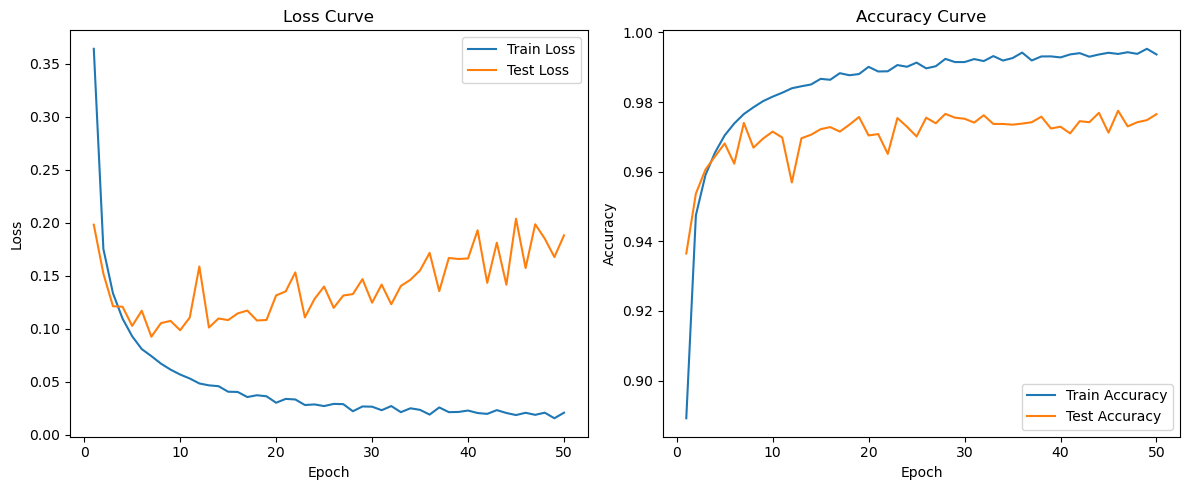

In [ ]:
train_model(model, test_loader=test_loader, train_loader=train_loader, num_epochs=50)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       1.00      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.99      0.97      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.98      0.98       892
           6       0.96      0.99      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.97      0.98      0.97       974
           9       0.95      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



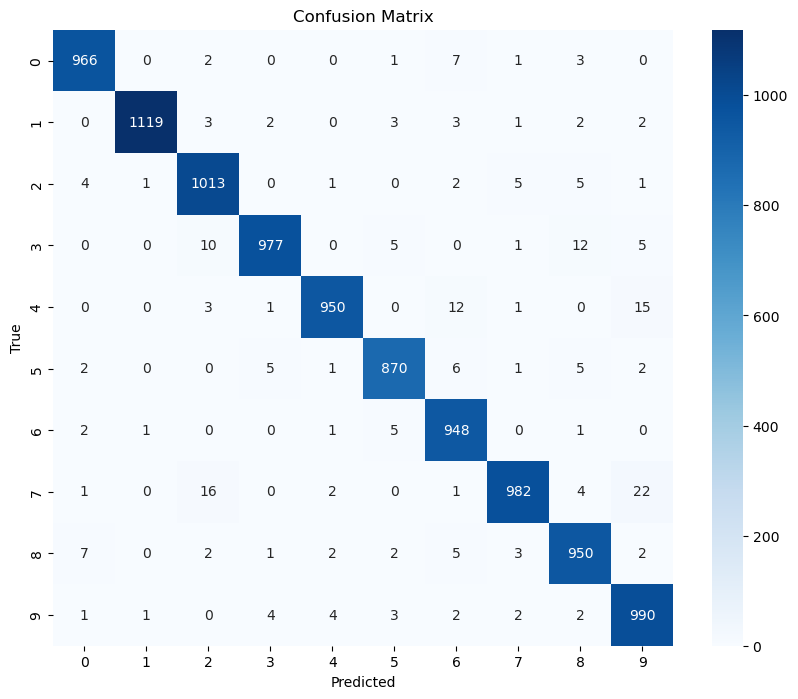

In [18]:
evaluate_model(model, test_loader)

In [63]:
# load the data from pickle
train_loader_3 = load_from_pickle("train_3.pkl")
train_loader_4 = load_from_pickle("train_4.pkl")
train_loader_7 = load_from_pickle("train_7.pkl")

In [64]:
def print_loader_info(loader, name):
    # Extract a batch of data
    images, labels = next(iter(loader))
    
    # Print information about the loader
    print(f"Information about {name}:")
    print(f"  - Image Shape: {images.shape}")  # e.g., (batch_size, channels, height, width)
    print(f"  - Label Shape: {labels.shape}")  # e.g., (batch_size,)
    print(f"  - Image Data Type: {images.dtype}")
    print(f"  - Label Data Type: {labels.dtype}")
    print(f"  - Number of Samples in {name}: {len(loader.dataset)}")
    print("-" * 50)

# Print information about the three loaders
print_loader_info(train_loader_3, "Train Loader 3")
print_loader_info(train_loader_4, "Train Loader 4")
print_loader_info(train_loader_7, "Train Loader 7")


Information about Train Loader 3:
  - Image Shape: torch.Size([32, 1, 28, 28])
  - Label Shape: torch.Size([32])
  - Image Data Type: torch.float32
  - Label Data Type: torch.int64
  - Number of Samples in Train Loader 3: 1000
--------------------------------------------------
Information about Train Loader 4:
  - Image Shape: torch.Size([32, 1, 28, 28])
  - Label Shape: torch.Size([32])
  - Image Data Type: torch.float32
  - Label Data Type: torch.int64
  - Number of Samples in Train Loader 4: 1000
--------------------------------------------------
Information about Train Loader 7:
  - Image Shape: torch.Size([32, 1, 28, 28])
  - Label Shape: torch.Size([32])
  - Image Data Type: torch.float32
  - Label Data Type: torch.int64
  - Number of Samples in Train Loader 7: 1000
--------------------------------------------------


In [ ]:

# Load datasets
train_loader_3 = load_from_pickle("train_3.pkl")
train_loader_4 = load_from_pickle("train_4.pkl")
train_loader_7 = load_from_pickle("train_7.pkl")

# Extract datasets from the DataLoaders
dataset_3 = train_loader_3.dataset
dataset_4 = train_loader_4.dataset
dataset_7 = train_loader_7.dataset

# Merge the datasets
merged_dataset = ConcatDataset([dataset_3, dataset_4, dataset_7])

# Create a new DataLoader for the merged dataset
merged_train_loader = DataLoader(merged_dataset, batch_size=64, shuffle=True)

# Now, `merged_train_loader` is your combined DataLoader


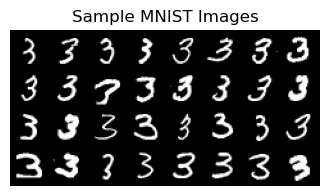

In [ ]:
plot_mnist_data(train_loader_3)

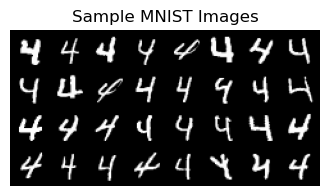

In [ ]:
plot_mnist_data(train_loader_4)

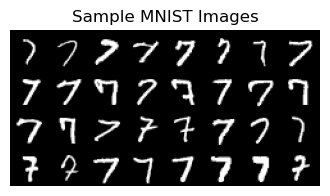

In [ ]:
plot_mnist_data(train_loader_7)

Epoch [1/10]: 100%|██████████| 32/32 [00:00<00:00, 143.02batch/s, Loss=0.1409]


Epoch [1/10] - Train Loss: 0.1409, Train Acc: 0.9840, Test Loss: 1.9081, Test Acc: 0.7860


Epoch [2/10]: 100%|██████████| 32/32 [00:00<00:00, 323.85batch/s, Loss=0.0026]


Epoch [2/10] - Train Loss: 0.0026, Train Acc: 0.9990, Test Loss: 3.2883, Test Acc: 0.6840


Epoch [3/10]: 100%|██████████| 32/32 [00:00<00:00, 265.32batch/s, Loss=0.0000]


Epoch [3/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.7217, Test Acc: 0.6526


Epoch [4/10]: 100%|██████████| 32/32 [00:00<00:00, 270.03batch/s, Loss=0.0000]


Epoch [4/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.7733, Test Acc: 0.6516


Epoch [5/10]: 100%|██████████| 32/32 [00:00<00:00, 267.87batch/s, Loss=0.0000]


Epoch [5/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.8364, Test Acc: 0.6512


Epoch [6/10]: 100%|██████████| 32/32 [00:00<00:00, 256.89batch/s, Loss=0.0000]


Epoch [6/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.8179, Test Acc: 0.6512


Epoch [7/10]: 100%|██████████| 32/32 [00:00<00:00, 267.82batch/s, Loss=0.0000]


Epoch [7/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.7513, Test Acc: 0.6511


Epoch [8/10]: 100%|██████████| 32/32 [00:00<00:00, 264.31batch/s, Loss=0.0000]


Epoch [8/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.7658, Test Acc: 0.6511


Epoch [9/10]: 100%|██████████| 32/32 [00:00<00:00, 258.54batch/s, Loss=0.0000]


Epoch [9/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.7494, Test Acc: 0.6511


Epoch [10/10]: 100%|██████████| 32/32 [00:00<00:00, 257.45batch/s, Loss=0.0000]


Epoch [10/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.7669, Test Acc: 0.6511
Fine-tuning complete!


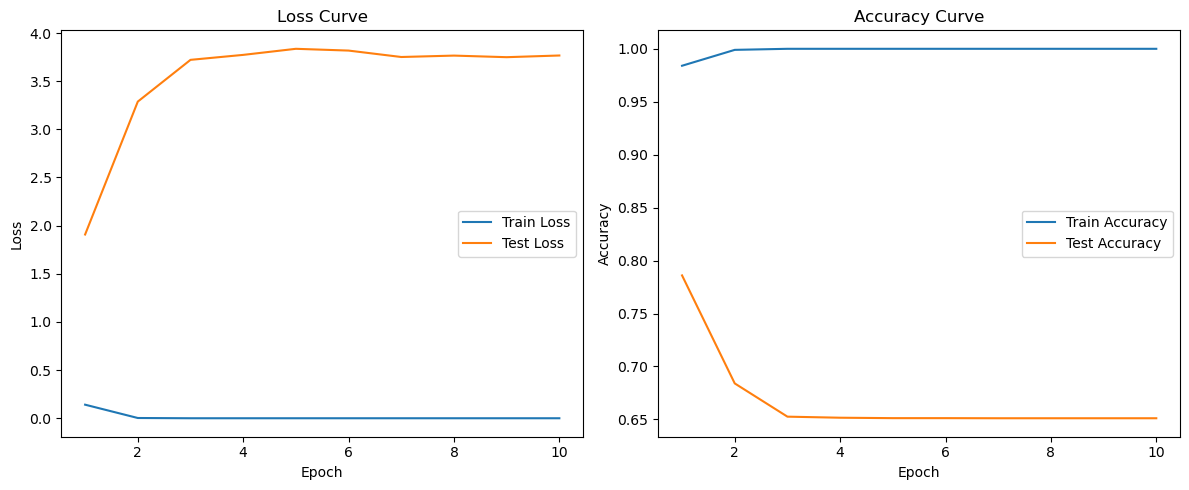

In [21]:
train_model(model, train_loader_3, test_loader=test_loader,num_epochs=10, fine_tuning=True)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       980
           1       1.00      0.57      0.73      1135
           2       0.95      0.64      0.77      1032
           3       0.24      1.00      0.39      1010
           4       0.99      0.63      0.77       982
           5       0.97      0.62      0.76       892
           6       0.97      0.93      0.95       958
           7       0.98      0.27      0.43      1028
           8       0.94      0.47      0.63       974
           9       0.76      0.46      0.57      1009

    accuracy                           0.65     10000
   macro avg       0.88      0.65      0.70     10000
weighted avg       0.88      0.65      0.69     10000



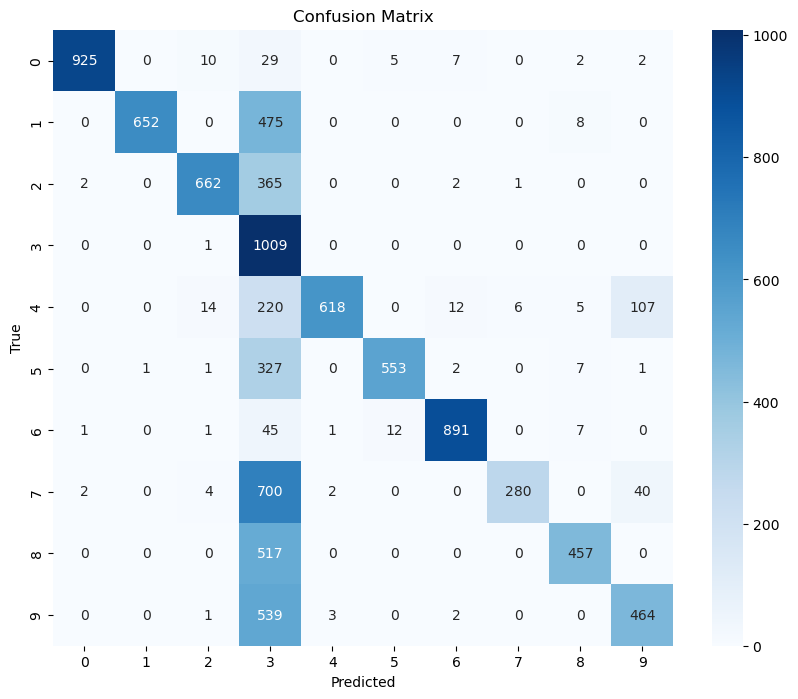

In [22]:
evaluate_model(model, test_loader)

Epoch [1/10]: 100%|██████████| 32/32 [00:00<00:00, 180.14batch/s, Loss=0.4238]


Epoch [1/10] - Train Loss: 0.4238, Train Acc: 0.9580, Test Loss: 0.9442, Test Acc: 0.8724


Epoch [2/10]: 100%|██████████| 32/32 [00:00<00:00, 224.63batch/s, Loss=0.0000]


Epoch [2/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.1965, Test Acc: 0.8476


Epoch [3/10]: 100%|██████████| 32/32 [00:00<00:00, 272.00batch/s, Loss=0.0000]


Epoch [3/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.2802, Test Acc: 0.8458


Epoch [4/10]: 100%|██████████| 32/32 [00:00<00:00, 287.17batch/s, Loss=0.0000]


Epoch [4/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.2121, Test Acc: 0.8456


Epoch [5/10]: 100%|██████████| 32/32 [00:00<00:00, 254.24batch/s, Loss=0.0000]


Epoch [5/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.2155, Test Acc: 0.8457


Epoch [6/10]: 100%|██████████| 32/32 [00:00<00:00, 260.24batch/s, Loss=0.0000]


Epoch [6/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.2389, Test Acc: 0.8456


Epoch [7/10]: 100%|██████████| 32/32 [00:00<00:00, 335.58batch/s, Loss=0.0000]


Epoch [7/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.2172, Test Acc: 0.8454


Epoch [8/10]: 100%|██████████| 32/32 [00:00<00:00, 186.75batch/s, Loss=0.0000]


Epoch [8/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.2258, Test Acc: 0.8455


Epoch [9/10]: 100%|██████████| 32/32 [00:00<00:00, 288.73batch/s, Loss=0.0000]


Epoch [9/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.2080, Test Acc: 0.8454


Epoch [10/10]: 100%|██████████| 32/32 [00:00<00:00, 265.36batch/s, Loss=0.0000]


Epoch [10/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.2252, Test Acc: 0.8452
Fine-tuning complete!


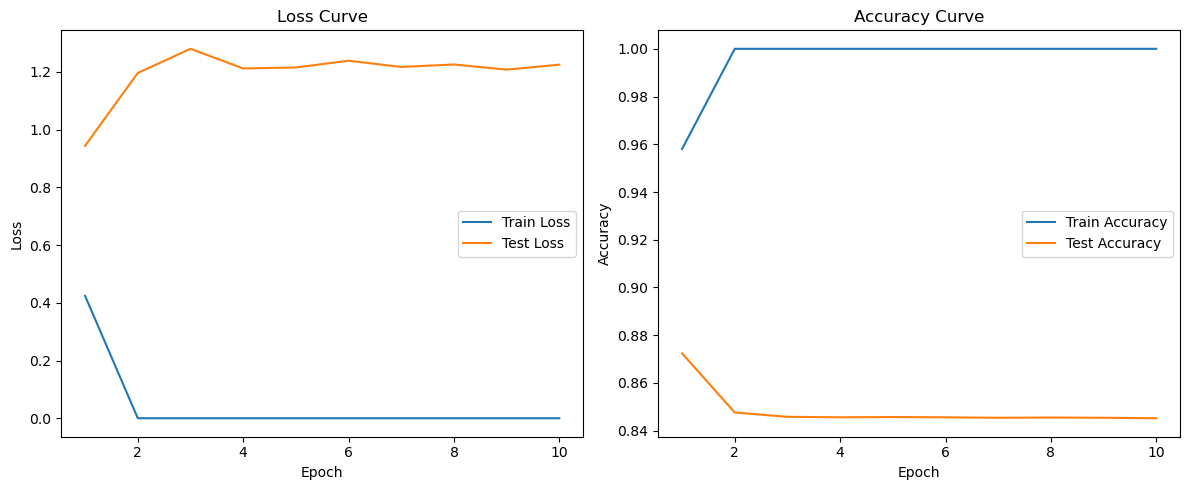

In [23]:
train_model(model, train_loader_4, test_loader=test_loader, num_epochs=10, fine_tuning=True )

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       980
           1       0.99      0.93      0.96      1135
           2       0.99      0.86      0.92      1032
           3       0.76      0.99      0.86      1010
           4       0.48      1.00      0.65       982
           5       0.99      0.75      0.85       892
           6       1.00      0.87      0.93       958
           7       0.98      0.74      0.85      1028
           8       0.94      0.87      0.90       974
           9       0.88      0.48      0.62      1009

    accuracy                           0.85     10000
   macro avg       0.90      0.84      0.85     10000
weighted avg       0.90      0.85      0.85     10000



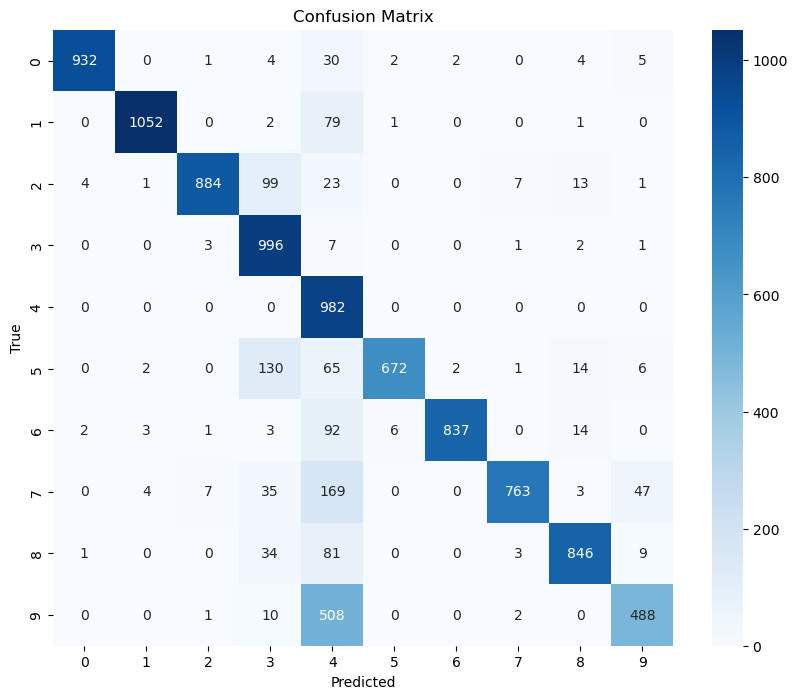

In [24]:
evaluate_model(model, test_loader)

Epoch [1/10]: 100%|██████████| 32/32 [00:00<00:00, 191.41batch/s, Loss=0.2201]


Epoch [1/10] - Train Loss: 0.2201, Train Acc: 0.9630, Test Loss: 1.1159, Test Acc: 0.8637


Epoch [2/10]: 100%|██████████| 32/32 [00:00<00:00, 263.20batch/s, Loss=0.0003]


Epoch [2/10] - Train Loss: 0.0003, Train Acc: 1.0000, Test Loss: 1.5508, Test Acc: 0.8282


Epoch [3/10]: 100%|██████████| 32/32 [00:00<00:00, 271.72batch/s, Loss=0.0000]


Epoch [3/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.5958, Test Acc: 0.8250


Epoch [4/10]: 100%|██████████| 32/32 [00:00<00:00, 220.53batch/s, Loss=0.0000]


Epoch [4/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.5924, Test Acc: 0.8248


Epoch [5/10]: 100%|██████████| 32/32 [00:00<00:00, 201.71batch/s, Loss=0.0000]


Epoch [5/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.6377, Test Acc: 0.8241


Epoch [6/10]: 100%|██████████| 32/32 [00:00<00:00, 271.79batch/s, Loss=0.0000]


Epoch [6/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.6037, Test Acc: 0.8239


Epoch [7/10]: 100%|██████████| 32/32 [00:00<00:00, 287.35batch/s, Loss=0.0000]


Epoch [7/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.6051, Test Acc: 0.8236


Epoch [8/10]: 100%|██████████| 32/32 [00:00<00:00, 269.54batch/s, Loss=0.0000]


Epoch [8/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.6375, Test Acc: 0.8236


Epoch [9/10]: 100%|██████████| 32/32 [00:00<00:00, 291.48batch/s, Loss=0.0000]


Epoch [9/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.6140, Test Acc: 0.8229


Epoch [10/10]: 100%|██████████| 32/32 [00:00<00:00, 284.29batch/s, Loss=0.0000]


Epoch [10/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.6053, Test Acc: 0.8228
Fine-tuning complete!


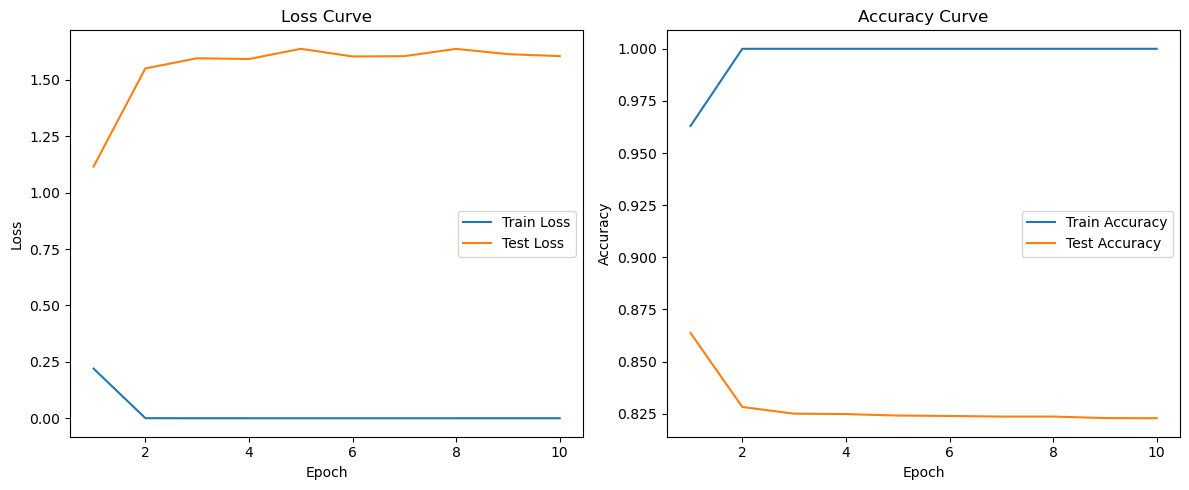

In [25]:
train_model(model, train_loader_7, test_loader=test_loader,num_epochs=10, fine_tuning=True)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       980
           1       0.99      0.93      0.96      1135
           2       0.99      0.80      0.88      1032
           3       0.77      0.96      0.85      1010
           4       0.83      0.94      0.88       982
           5       0.99      0.65      0.79       892
           6       0.99      0.88      0.94       958
           7       0.46      1.00      0.63      1028
           8       0.97      0.76      0.85       974
           9       0.99      0.32      0.48      1009

    accuracy                           0.82     10000
   macro avg       0.90      0.82      0.82     10000
weighted avg       0.90      0.82      0.82     10000



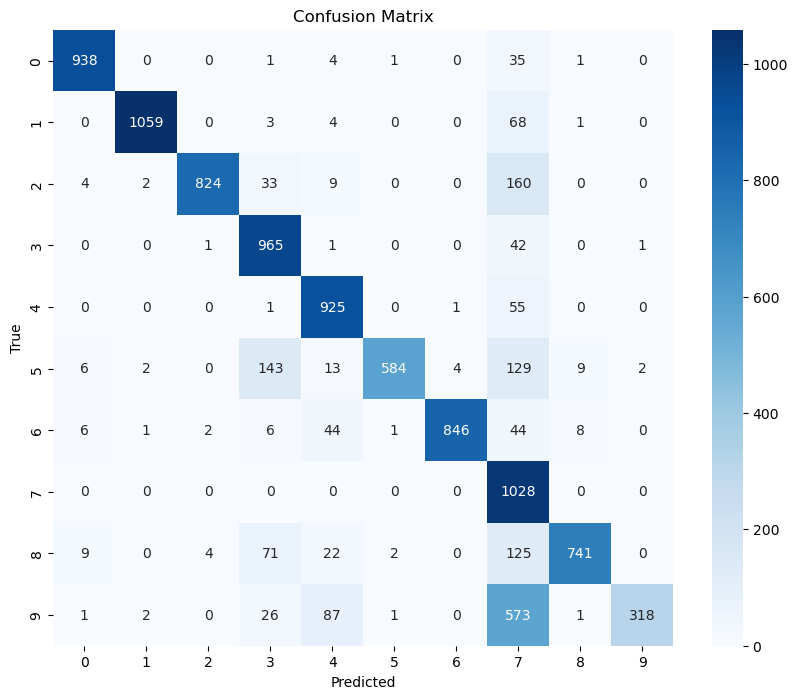

In [26]:
evaluate_model(model, test_loader)

Epoch [1/10]: 100%|██████████| 47/47 [00:00<00:00, 208.37batch/s, Loss=0.0651]


Epoch [1/10] - Train Loss: 0.0651, Train Acc: 0.9877, Test Loss: 1.7160, Test Acc: 0.7999


Epoch [2/10]: 100%|██████████| 47/47 [00:00<00:00, 264.75batch/s, Loss=0.0180]


Epoch [2/10] - Train Loss: 0.0180, Train Acc: 0.9950, Test Loss: 1.7932, Test Acc: 0.7735


Epoch [3/10]: 100%|██████████| 47/47 [00:00<00:00, 249.09batch/s, Loss=0.0071]


Epoch [3/10] - Train Loss: 0.0071, Train Acc: 0.9973, Test Loss: 1.9507, Test Acc: 0.7448


Epoch [4/10]: 100%|██████████| 47/47 [00:00<00:00, 211.98batch/s, Loss=0.0027]


Epoch [4/10] - Train Loss: 0.0027, Train Acc: 0.9990, Test Loss: 2.0382, Test Acc: 0.7327


Epoch [5/10]: 100%|██████████| 47/47 [00:00<00:00, 278.50batch/s, Loss=0.0006]


Epoch [5/10] - Train Loss: 0.0006, Train Acc: 1.0000, Test Loss: 2.1024, Test Acc: 0.7319


Epoch [6/10]: 100%|██████████| 47/47 [00:00<00:00, 285.86batch/s, Loss=0.0002]


Epoch [6/10] - Train Loss: 0.0002, Train Acc: 1.0000, Test Loss: 2.1775, Test Acc: 0.7261


Epoch [7/10]: 100%|██████████| 47/47 [00:00<00:00, 280.66batch/s, Loss=0.0001]


Epoch [7/10] - Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 2.1768, Test Acc: 0.7242


Epoch [8/10]: 100%|██████████| 47/47 [00:00<00:00, 268.50batch/s, Loss=0.0001]


Epoch [8/10] - Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 2.2019, Test Acc: 0.7233


Epoch [9/10]: 100%|██████████| 47/47 [00:00<00:00, 272.75batch/s, Loss=0.0001]


Epoch [9/10] - Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 2.2289, Test Acc: 0.7223


Epoch [10/10]: 100%|██████████| 47/47 [00:00<00:00, 276.99batch/s, Loss=0.0001]


Epoch [10/10] - Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 2.2471, Test Acc: 0.7218
Fine-tuning complete!


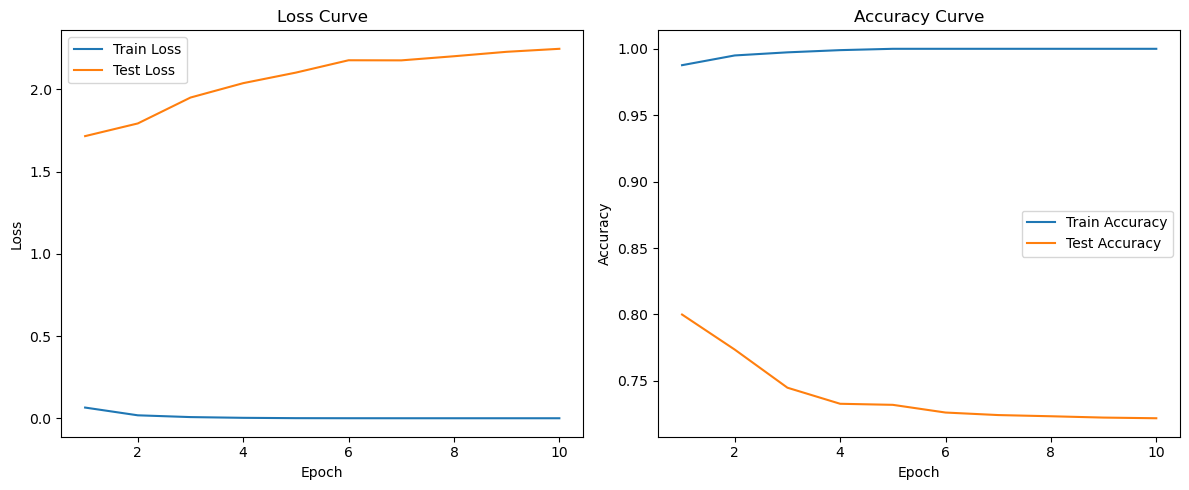

In [27]:
train_model(model, merged_train_loader, test_loader=test_loader, num_epochs=10, fine_tuning=True)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       980
           1       0.95      0.21      0.35      1135
           2       0.99      0.37      0.54      1032
           3       0.53      0.96      0.68      1010
           4       0.73      0.83      0.77       982
           5       0.96      0.63      0.76       892
           6       1.00      0.80      0.89       958
           7       0.28      1.00      0.44      1028
           8       0.99      0.34      0.51       974
           9       0.97      0.15      0.27      1009

    accuracy                           0.62     10000
   macro avg       0.84      0.62      0.62     10000
weighted avg       0.84      0.62      0.61     10000



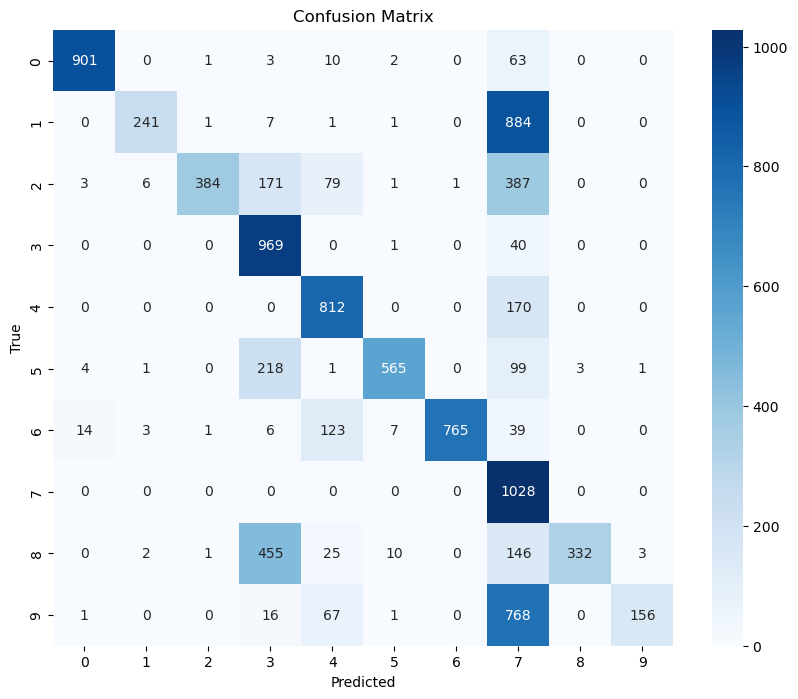

In [ ]:
evaluate_model(model, test_loader)

In [ ]:
# Save the model
torch.save(model.state_dict(), pretrained_model_path)
print("Model saved successfully!")

Model saved successfully!
